In [1]:
# %matplotlib notebook

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 80% !important; }</style>"))

In [3]:
from IPython.display import Video

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import random
import cv2

from tqdm.auto import tqdm

plt.style.use('seaborn-pastel')

from IPython.display import Image
from IPython.display import HTML

tf.__version__

'2.1.0'

In [1009]:
def dense(size, activation):
    return tf.keras.layers.Dense(
        size,
        activation=activation,
        kernel_initializer=tf.random_normal_initializer(0, 1),
        bias_initializer=tf.random_normal_initializer(0, 1)
    )

class CPPNUV:
    def __init__(self, width, depth, mirror=False):
        self.layers = []
        self.mirror = mirror
        for i in range(depth):
            self.layers.append(dense(
                width, tf.math.tanh if i < 2 else tf.nn.sigmoid
            ))

        # output uv map
        self.layers.append(dense(2, tf.sigmoid))

    def generate_input_mesh(self, size):
        w, h = size
        ar = w / h
        x = np.linspace(-ar / 2, ar / 2, w)
        y = np.linspace(-0.5, 0.5, h)
        
        if self.mirror:
            x = np.abs(x)
            y = np.abs(y)
        
        xx, yy = np.meshgrid(x, y)
        mesh = np.stack((xx.reshape(-1), yy.reshape(-1)), axis=-1)

        return mesh

    def generate(self, z, im_size=(128, 128)):
        mesh = self.generate_input_mesh(im_size)
        # Add z to input
        result = np.concatenate((np.tile(z, (mesh.shape[0], 1)), mesh), axis=-1)
        result = np.float32(result)

        for d in self.layers:
            result = d(result)

        img = result.numpy().reshape(*im_size[::-1], -1)
        return img

In [1010]:
def normalize(xx):
    return ((xx - np.min(xx)) / (np.max(xx) - np.min(xx))).astype(np.float32)

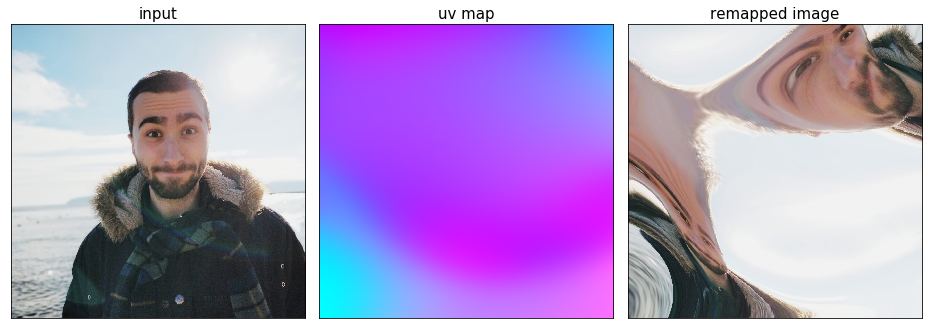

In [1014]:
im = cv2.imread('avatar.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
W, H, _ = im.shape

uv = CPPNUV(40, 8, mirror=False).generate(1, im_size=(W, H))
xx = uv[:, :, 0]
yy = uv[:, :, 1]

norm_xx = (xx - np.min(xx)) / (np.max(xx) - np.min(xx))
norm_yy = (yy - np.min(yy)) / (np.max(yy) - np.min(yy))
norm_zz = np.ones_like(norm_xx)
n_map = np.stack((norm_xx, norm_yy, norm_zz), axis=-1)


out = cv2.remap(im, norm_xx * im.shape[0], norm_yy * im.shape[1], cv2.INTER_AREA)

fig, axs = plt.subplots(1, 3, figsize=(13, 10))

axs[0].imshow(im)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title('input', fontsize=15)

axs[1].set_title('uv map', fontsize=15)
axs[1].imshow(n_map)
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[2].set_title('remapped image', fontsize=15)
axs[2].imshow(out)
axs[2].set_xticks([])
axs[2].set_yticks([])

fig.tight_layout()

In [1015]:
def make_sampler(img_path, ppn_ctor, cols, rows):
    im = cv2.imread(img_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    # Save the networks
    cppns = []
    for r in range(rows):
        cppns.append([])
        for c in range(cols):
            cppns[-1].append(ppn_ctor(r, c))

    # Sample from the networks
    def sampler(z, w, h):
        rows_of_images = []
        for r in range(rows):
            row_of_images = []
            for c in range(cols):
                uv = cppns[r][c].generate(z, im_size=(w // cols, h // rows))
                xx = uv[:, :, 0]
                yy = uv[:, :, 1]

                # Normalize the output
                norm_xx = (xx - np.min(xx)) / (np.max(xx) - np.min(xx))
                norm_yy = (yy - np.min(yy)) / (np.max(yy) - np.min(yy))

                out = cv2.remap(im, norm_xx * im.shape[0], norm_yy * im.shape[1], cv2.INTER_AREA)
                row_of_images.append(out)

            row = np.concatenate(row_of_images, axis=1)
            rows_of_images.append(row)

        return np.concatenate(rows_of_images, axis=0)

    return sampler

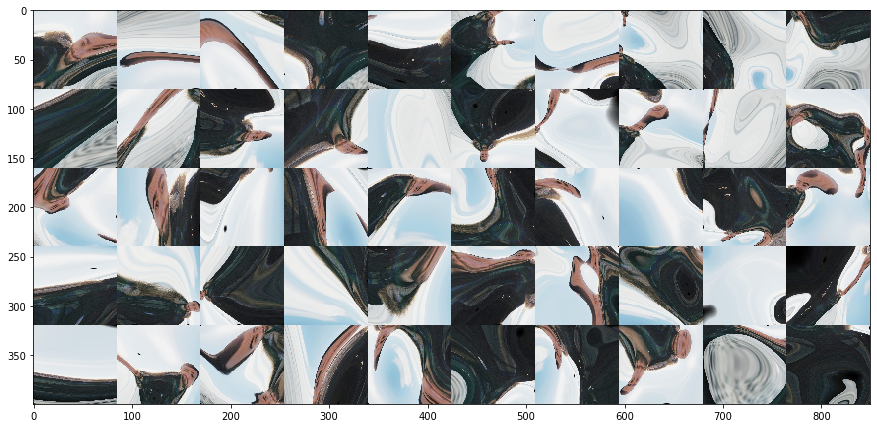

In [1016]:
imgs = make_sampler(
    'avatar.jpg',
    lambda r, c: CPPNUV(8 + c * 2, 3, mirror=False),
    cols=10,
    rows=5,
)(z=1, w=850, h=400)

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(imgs)

In [1017]:
def make_anim(vid_path, img_path, ppn_ctor, cols, rows, duration, W, H):
    sampler = make_sampler(img_path, ppn_ctor, cols, rows)
    z_start = np.random.normal(0, 1, size=32)
    z_mid = z_start + np.random.normal(0, 0.1, size=32)
    z_end = z_mid + np.random.normal(0, 0.1
                                     , size=32)

    img = sampler(z_start, W, H)

    frames = 30 * duration # 30fps

    def animate(i):
        lerp = i / frames

        z_1 = z_start * lerp + z_mid * (1 - lerp)
        z_2 = z_mid * lerp + z_end * (1 - lerp)
        z_3 = z_end * lerp + z_start * (1 - lerp)

        z_11 = z_1 * lerp + z_2 * (1 - lerp)
        z_12 = z_2 * lerp + z_3 * (1 - lerp)

        z = z_11 * lerp + z_12 * (1 - lerp)

        return sampler(z, W, H)

    actual_H, actual_W, _ = img.shape
    fourcc = cv2.VideoWriter_fourcc(*'VP80')
    video = cv2.VideoWriter(vid_path, fourcc, 30.0, (actual_W, actual_H))

    for i in tqdm(range(frames)):
        img = animate(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video.write(img)

    video.release()

In [1022]:
d = 100000
vid_path = 'v_' + str(d + np.random.randint(d)) + '.webm'

make_anim(
    vid_path,
    'avatar.jpg',
    lambda r, c: CPPNUV(30 + c * 5, 6 + r * 2, mirror=False),
    cols=5,
    rows=2,
    W=850,
    H=400,
    duration=2
)

In [1023]:
HTML("""
    <video alt="test" autoplay="autoplay" loop>
        <source src="./%s">
    </video>
""" % vid_path)